<a href="https://colab.research.google.com/github/monouns/Portfolio-Allocation-tutorial/blob/master/Markowitz_Portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Make Dataset with FinanceDataReader

In [ ]:
!pip install finance-datareader --upgrade

In [ ]:
import FinanceDataReader as fdr
fdr.__version__

'0.9.33'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Colab Notebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks


In [ ]:
import numpy as np
import pandas as pd
import re
from itertools import product
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco

In [ ]:
#You must have stock_list.csv file before running the code!
stock_list = pd.read_csv('./stock_list.csv')
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))
stock_list.set_index('종목코드', inplace=True)
stock_list

,종목명,종목코드,상장시장
0,삼성전자,005930,KOSPI
1,SK하이닉스,000660,KOSPI
2,NAVER,035420,KOSPI
3,카카오,035720,KOSPI
4,삼성바이오로직스,207940,KOSPI
...,...,...,...
365,맘스터치,220630,KOSDAQ
366,다날,064260,KOSDAQ
367,제이시스메디칼,287410,KOSDAQ
368,크리스에프앤씨,110790,KOSDAQ


In [ ]:
ticker=  stock_list['종목코드']
datetime = ['2022-01-01', '2022-05-22']
data = pd.DataFrame()
#data = pd.read_csv('./data.csv') 
for code in tqdm(list(ticker)):
    df = pd.DataFrame()
    stock = fdr.DataReader(code, start = datetime[0], end = datetime[1])
    if not stock.empty:
      df[code] = stock['Close']

      df.reset_index(inplace=True, drop=True)

      data = pd.concat([data, df], axis=1)
data = data.interpolate(method='linear', limit_direction='both')
data

  0%|          | 0/370 [00:00<?, ?it/s]

In [ ]:
data.to_csv('./data.csv', index=0)

# Efficient Frontiner from Modern Portfolio Theory implemented in Python (Markowitz Portfolio Theory)

In [ ]:
data = pd.read_csv('./data.csv')

In [ ]:
num_assets = 200
table = data.copy().iloc[:, :num_assets]
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
risk_free_rate = 0.0178

In [ ]:
an_vol = pd.DataFrame(np.std(returns) * np.sqrt(94), columns=['vol'])
an_rt = pd.DataFrame(mean_returns * 94, columns=['rt'])

In [ ]:
an_rt.describe()

,rt
count,200.000000
mean,-0.058588
std,0.189259
min,-0.717570
25%,-0.162273
50%,-0.054317
75%,0.057951
max,0.607462


In [ ]:
an_vol.describe()

,vol
count,200.000000
mean,0.221283
std,0.083073
min,0.001110
25%,0.167664
50%,0.220559
75%,0.264303
max,0.569313


In [ ]:
an_rt[an_rt['rt']>0.1].index

Index(['055550', '011200', '086790', '010950', '010130', '030200', '316140',
       '086280', '035250', '267250', '078930', '028670', '004990', '005830',
       '008560', '010620', '036460', '047810', '023530', '010060', '002380',
       '000060', '030000', '282330', '000080', '006260', '001450', '001440',
       '252670', '001230', '069620', '004000', '111770', '016380', '031430',
       '005300', '247540', '028300', '066970'],
      dtype='object')

In [ ]:
an_vol[an_vol['vol']<0.3].index

Index(['005930', '000660', '035420', '035720', '207940', '005935', '006400',
       '005380', '068270', '000270',
       ...
       '161890', '005300', '004490', '214320', '035760', '145020', '253450',
       '058470', '357780', '240810'],
      dtype='object', length=173)

In [ ]:
table = table.loc[:, an_rt[an_rt['rt']>0.1].index & an_vol[an_vol['vol']<0.3].index]
table

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  """Entry point for launching an IPython kernel.


,055550,086790,010950,010130,030200,316140,086280,035250,267250,078930,...,000080,006260,001450,252670,001230,069620,004000,111770,031430,005300
0,37250,42350,85900,510000,30350,12800,172500,24200,53600,39400,...,30250,54500,23450,2150,16100,151500,73000,44150,29100,131000
1,37600,42700,90200,511000,30100,13000,173000,23950,54900,39550,...,30300,55000,24050,2155,17150,147500,74800,44600,29100,132500
2,37500,43000,90200,503000,30800,13050,173000,24000,55500,39550,...,29900,54000,24950,2215,17400,144500,74500,46050,28400,131000
3,37300,43200,92400,509000,30250,12850,184000,24100,54800,40050,...,30450,54000,25300,2260,18100,141000,72600,47750,28000,131000
4,37650,43450,97300,514000,30250,13100,184000,24550,55500,39700,...,30750,54500,25450,2195,18250,143000,75500,47300,28100,136000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,42350,46450,109500,552000,36650,15700,206000,27550,59800,46800,...,35850,59400,31250,2720,17650,164000,81000,48250,33650,186500
90,42400,46250,113000,552000,36550,15700,208000,27100,60900,47000,...,36950,60600,30950,2665,17900,164500,83300,48550,34400,189500
91,42050,46200,110000,557000,36250,14900,209500,27200,61400,46000,...,36800,59400,31050,2655,17650,167500,82900,50400,34350,182500
92,40700,45300,107000,561000,36350,14200,201500,26650,60400,45450,...,36100,60500,30850,2735,16800,162000,82000,46250,34200,182500


In [ ]:
num_assets = len(table.columns)

In [ ]:
an_rt = an_rt.loc[table.columns]
an_vol = an_vol.loc[table.columns]

In [ ]:
# Making a dataframe for log return
df_logret = np.log(table / table.shift(1))
df_logret = df_logret.dropna()

In [ ]:
# calculate mu 

mu_df = df_logret.mean() * len(df_logret)
mu = mu_df.to_numpy()

In [ ]:
mu

array([0.11284918, 0.10311478, 0.21025527, 0.11647499, 0.16933257,
       0.13157636, 0.17747893, 0.10391319, 0.11279549, 0.14942598,
       0.35325798, 0.1360408 , 0.15573672, 0.14695441, 0.11460338,
       0.12600641, 0.36303764, 0.10848064, 0.06544391, 0.12345856,
       0.25941164, 0.16144397, 0.107743  , 0.25462569, 0.201516  ,
       0.06609011, 0.07622737, 0.14035736, 0.06785973, 0.16294839,
       0.33155285])

In [ ]:
# calculate Sigma

Sigma_df = df_logret.cov() * len(df_logret)
Sigma = Sigma_df.to_numpy()

In [ ]:
# # Import cvxpy for solving optimization problem
import cvxpy as cp

In [ ]:
# Minimum volatility portfolio optmization
w_1 = cp.Variable(num_assets)

risk_1 = cp.quad_form(w_1, Sigma)

prob = cp.Problem(cp.Minimize(risk_1),
                 [cp.sum(w_1) == 1,
                  w_1 >= 0])

prob.solve()

print('> Expected return of the portfolio is ', round(mu.dot(w_1.value), 4))
print('> Standard deviation of the portfolio is ', round(np.sqrt(w_1.value.dot(Sigma).dot(w_1.value)), 4))

> Expected return of the portfolio is  0.1621
> Standard deviation of the portfolio is  0.0411


In [ ]:
min_vol = np.sqrt(w_1.value.dot(Sigma).dot(w_1.value))
min_vol_ret = mu.dot(w_1.value)
print(min_vol_ret)

0.16210592348153052


In [ ]:
# Maximize return potfolio optimization
w_2 = cp.Variable(num_assets)

ret_2 = mu.T@w_2

prob = cp.Problem(cp.Maximize(ret_2),
                 [cp.sum(w_2) == 1,
                  w_2 >= 0])

prob.solve()

print('> Expected return of the portfolio is ', round(mu.dot(w_2.value), 4))
print('> Standard deviation of the portfolio is ', round(np.sqrt(w_2.value.dot(Sigma).dot(w_2.value)), 4))

> Expected return of the portfolio is  0.363
> Standard deviation of the portfolio is  0.2631


In [ ]:
max_ret = mu.dot(w_2.value)
max_ret_vol = np.sqrt(w_2.value.dot(Sigma).dot(w_2.value))
print(max_ret)

0.36303763726705995


In [ ]:
# Making a feasible set
num_simulation = 10000
all_weights = np.zeros((num_simulation, len(table.columns)))
ret_ = np.zeros(num_simulation)
vol_ = np.zeros(num_simulation)
sharpe_ = np.zeros(num_simulation)

for x in range(num_simulation):
    # Weights
    weights = np.array(np.random.random(len(table.columns)))
    weights = weights / np.sum(weights) #Normalization for weight_sum = 1
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_[x] = mu.dot(weights)
    
    # Expected volatility
    vol_[x] = np.sqrt(weights.dot(Sigma).dot(weights))
    
    # Sharpe Ratio
    sharpe_[x] = ret_[x] / vol_[x]

In [ ]:
# Making an efficient frontier
x_ef = []
y_ef = np.linspace(min_vol_ret, max_ret, 1000)

for possible_return in y_ef:
    w = cp.Variable(num_assets)

    lambda0 = possible_return
    ret = mu.T@w
    risk = cp.quad_form(w, Sigma)

    prob = cp.Problem(cp.Minimize(risk),
                     [cp.sum(w) == 1,
                      ret == lambda0,
                      w >= 0])

    prob.solve()
    x_ef.append(np.sqrt(w.value.dot(Sigma).dot(w.value)))

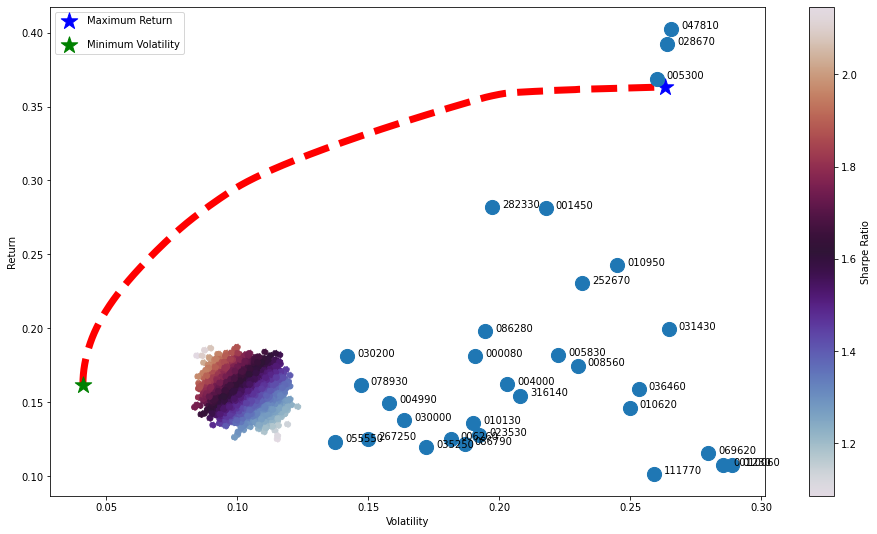

In [ ]:
# Drawing a feasible region and an efficient frontier

plt.figure(figsize=(16,9))
plt.scatter(vol_, ret_, c=sharpe_, linestyle='-.', cmap='twilight')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(x_ef, y_ef, 'r--', linewidth=7, zorder = 0)
plt.scatter(max_ret_vol, max_ret, marker='*',color='b',s=300, label='Maximum Return', zorder = 1)
plt.scatter(min_vol, min_vol_ret,marker='*',color='g',s=300, label='Minimum Volatility', zorder = 2)
plt.scatter(an_vol,an_rt, marker='o',s=200)
for i, txt in enumerate(table.columns):
    plt.annotate(txt, (an_vol.loc[txt],an_rt.loc[txt]), xytext=(10,0), textcoords='offset points')
plt.legend(labelspacing=1.4)
plt.savefig('answer.png')
plt.show()

In [ ]:
weight = pd.DataFrame([np.round(w_1.value*100, 1), np.round(w_2.value*100, 1)]).T
weight.index = table.columns

In [ ]:
w1 = pd.DataFrame()
w1['weight'] = weight[0]
w1['filter'] = weight[0]>0
w1 = pd.DataFrame(w1['weight'].loc[w1['filter']==True])
w1 = pd.concat([w1, stock_list['종목명'].loc[w1.index.values]], axis=1)
w1

,weight,종목명
055550,9.1,신한지주
030200,4.3,KT
086280,8.0,현대글로비스
035250,0.1,강원랜드
267250,2.8,현대중공업지주
028670,0.3,팬오션
004990,14.8,롯데지주
008560,6.0,메리츠증권
047810,1.5,한국항공우주
010060,5.8,OCI


In [ ]:
tmp = pd.DataFrame()
tmp['매수'] = w1['weight']*20000 #for 20million won
tmp['종목명'] = w1['종목명']
tmp.set_index('종목명', inplace=True)
tmp

,매수
종목명,
신한지주,182000.0
KT,86000.0
현대글로비스,160000.0
강원랜드,2000.0
현대중공업지주,56000.0
팬오션,6000.0
롯데지주,296000.0
메리츠증권,120000.0
한국항공우주,30000.0


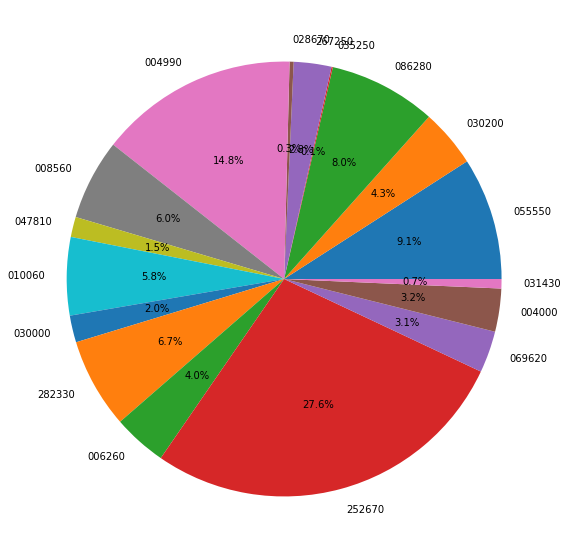

In [ ]:
plt.figure(figsize=(10,10))
plt.pie(w1['weight'], labels=w1.index, autopct='%.1f%%')
plt.show()

In [ ]:
w2 = pd.DataFrame()
w2['weight'] = weight[1]
w2['filter'] = weight[1]>0
w2 = pd.DataFrame(w2['weight'].loc[w2['filter']==True])
w2 = pd.concat([w2, stock_list['종목명'].loc[w2.index.values]], axis=1)
w2

,weight,종목명
047810,100.0,한국항공우주
